## Would you survive the Titanic Disaster?
In this project we develop a machine laerning model on the famous Titanic dataset. The goal is to predict the fate of the passengers, whether they would survive the accident. The dataset is publicly avaivalbe in Kaggle. We have a train and test dataset. 

## Accessing the Data

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
test =  pd.read_csv("test.csv")

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# We have 891 rows and 12 columns (11 features + 1 label) in the training dataset.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Preprocessing the Data
We have some columns that contain missing values. Also we need to create numeric features with same scale.  

## Missing values

In [4]:
total = train.isnull().sum().sort_values(ascending=False)
percentage = train.isnull().sum()/train.isnull().count()*100
percentage_round = (round(percentage, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percentage_round], axis=1, keys=['Total', '%'])
missing_data.head(5)
# So "Cabin", "Age" and "Embarked" have missing values

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


## Handling missing values and categorical features

In [5]:
# %load functions.py
def processing_embarked(df):

    df["Embarked"] = df["Embarked"].fillna("S")
    
    return df

def processing_age(df):
    
    ## Filling the missing ages
    #df["Age"] = df["Age"].fillna(-0.5)
    df["Age"] = df["Age"].fillna(train["Fare"].mean())
    
    ## Data binning
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_Groups"] = pd.cut(df["Age"],cut_points,labels=label_names)
    
    return df

def processing_fare(df):
    
    ## Filling the missing fares
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    
    ## Data binning
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_Groups"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    
    return df

def processing_cabin(df):
    
    ## Data binning and filling the missing values
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    
    return df

def processing_titles(df):
    
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    
    return df

def one_hot_encoding(df,column_name):
    
    one_hot_encoding = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df, one_hot_encoding],axis=1)
    
    return df

In [6]:
def pre_processing(df):
    df = processing_embarked(df)
    df = processing_age(df)
    df = processing_fare(df)
    df = processing_titles(df)
    df = processing_cabin(df)

    for col in ["Age_Groups","Fare_Groups",
                "Title","Cabin_type","Sex", "Embarked"]:
        df = one_hot_encoding(df,col)
    
    return df

train = pre_processing(train)
test = pre_processing(test)

## Exploring the Data

In [7]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB


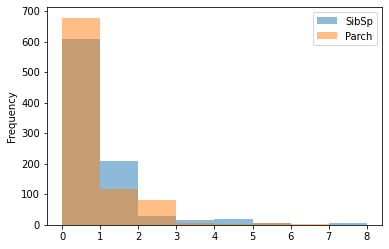

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

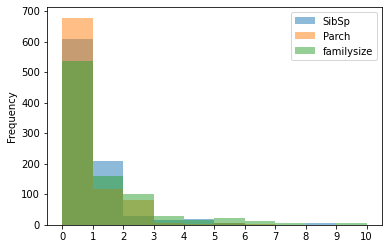

In [9]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

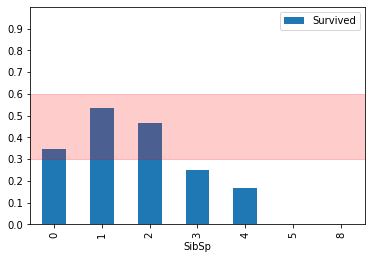

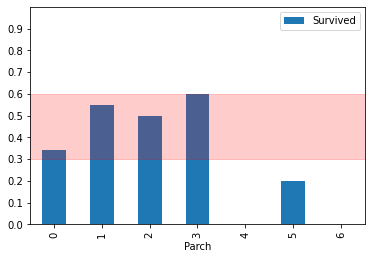

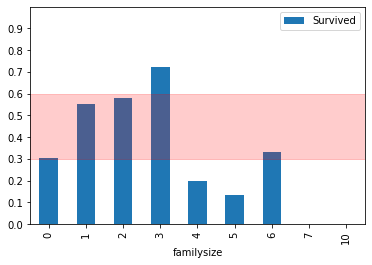

In [10]:
import numpy as np

for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

## Observations about 'SibSp' and 'Parch'
The `SibSp` column shows the number of siblings and/or spouses each passenger had on board, while the `Parch` columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

We can sum these two columns to explore the total number of family members each passenger had onboard.  The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, we can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

## Engineering New Features

In [11]:
def processing_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = processing_isalone(train)
test = processing_isalone(test)

## Selecting the Best-Performing Features

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)
print("Hello")

Best Columns 
------------
['Pclass', 'Age', 'Fare', 'Title_Mr', 'Sex_female', 'Sex_male']

Hello


## Selecting and Tuning Different Algorithms

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"],
                    "max_iter": [200]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            scoring = 'roc_auc',
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,cols)

LogisticRegression
------------------
Best Score: 0.8555550179667828
Best Parameters: {'max_iter': 200, 'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.8118287638287638
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}

RandomForestClassifier
----------------------
Best Score: 0.878785841609371
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 9}



## Making a Submission to Kaggle

In [ ]:
def save_submission_file(model,cols,filename="submission.csv"):
    test_data = test[cols]
    predictions = model.predict(holdout_data)
    
    test_ids = test["PassengerId"]
    submission_df = {"PassengerId": test_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,cols)